In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py, glob
import pandas as pd
import random
import scipy.integrate as integrate

from random import choices
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp
from ang_res_funcs import *

In [2]:
PARENT_DIRECTORY = '/data/ana/CosmicRay/Anisotropy/IceTop/twelve_year/03_sim_study'
DIRECTS = [f'{PARENT_DIRECTORY}/IT81-2012', f'{PARENT_DIRECTORY}/IT81-2015', f'{PARENT_DIRECTORY}/IT81-2018']
COLORS = ['green', 'blue', 'red']
LABELS = ['2012', '2015', '2018']

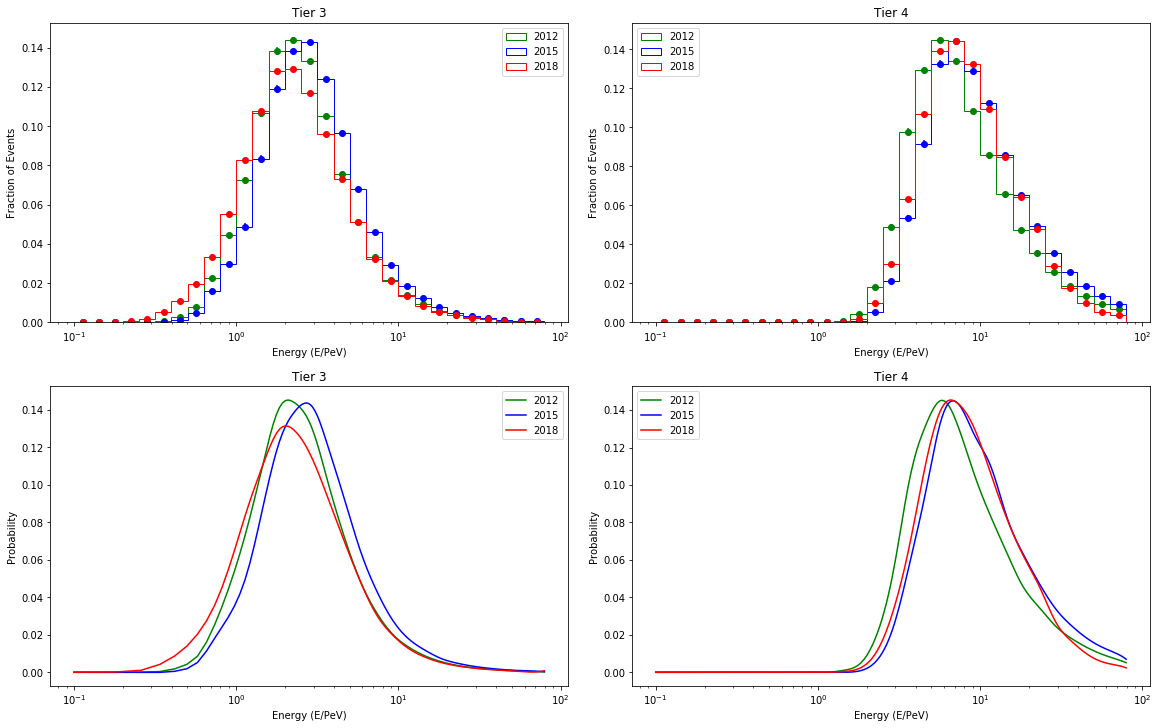

In [17]:
# Initialize histogram array
histograms = plt.figure(figsize=(16, 10), constrained_layout=True)
hist_array = histograms.subplots(2, 2, squeeze=False)

hist_array[0,0].set_title('Tier 3')
hist_array[0,0].semilogx()
hist_array[0,0].set_ylabel('Fraction of Events')
hist_array[0,0].set_xlabel('Energy (E/PeV)')

hist_array[0,1].set_title('Tier 4')
hist_array[0,1].semilogx()
hist_array[0,1].set_ylabel('Fraction of Events')
hist_array[0,1].set_xlabel('Energy (E/PeV)')

hist_array[1,0].set_title('Tier 3')
hist_array[1,0].semilogx()
hist_array[1,0].set_ylabel('Probability')
hist_array[1,0].set_xlabel('Energy (E/PeV)')

hist_array[1,1].set_title('Tier 4')
hist_array[1,1].semilogx()
hist_array[1,1].set_ylabel('Probability')
hist_array[1,1].set_xlabel('Energy (E/PeV)')

# Initialize lists to store data for KS test
all_hist_t3 = []
all_hist_t4 = []

for i, DIRECT in enumerate(DIRECTS):
    # Load energy and weight arrays
    mc_en_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Energy.npy')
    mc_en_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Energy.npy')
    mc_en_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Energy.npy')
    mc_en_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Energy.npy')
    
    mc_en_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Energy.npy')
    mc_en_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Energy.npy')
    mc_en_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Energy.npy')
    mc_en_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Energy.npy')
    
    mc_w_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Weights.npy')
    mc_w_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Weights.npy')
    mc_w_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Weights.npy')
    mc_w_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Weights.npy')
    
    mc_w_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Weights.npy')
    mc_w_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Weights.npy')
    mc_w_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Weights.npy')
    mc_w_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Weights.npy')

    # Concatenate arrays
    mc_en_t3 = np.concatenate((mc_en_p_t3, mc_en_he_t3, mc_en_o_t3, mc_en_fe_t3), axis=None)
    mc_en_t4 = np.concatenate((mc_en_p_t4, mc_en_he_t4, mc_en_o_t4, mc_en_fe_t4), axis=None)
    
    mc_w_t3 = np.concatenate((mc_w_p_t3, mc_w_he_t3, mc_w_o_t3, mc_w_fe_t3), axis=None)
    mc_w_t4 = np.concatenate((mc_w_p_t4, mc_w_he_t4, mc_w_o_t4, mc_w_fe_t4), axis=None)

    # Define bins for histogram and scale (to convert from GeV to PeV) 
    bins = 10**(np.arange(-1,2,.1))
    scale = 10**-6

    ######################################## Tier 3 Fraction ########################################
    
    hist_t3, bin_edges_t3 = np.histogram(mc_en_t3 * scale, bins=bins, weights=mc_w_t3 / sum(mc_w_t3))
    bin_centers_t3 = (bin_edges_t3[:-1] + bin_edges_t3[1:]) / 2
    weighted_uncertainty_t3 = np.sqrt(np.histogram(mc_en_t3 * scale, bins=bins, weights=(mc_w_t3 / sum(mc_w_t3))**2)[0])
    
    hist_array[0,0].hist(mc_en_t3*scale, bins, weights=mc_w_t3/sum(mc_w_t3), histtype="step", linestyle="solid", color=COLORS[i], label=LABELS[i])
    hist_array[0,0].errorbar(bin_centers_t3, hist_t3, yerr=weighted_uncertainty_t3, fmt='o', color=COLORS[i])    
    hist_array[0,0].legend(loc='upper right')

    ######################################## Tier 4 Fraction ########################################
    hist_t4, bin_edges_t4 = np.histogram(mc_en_t4 * scale, bins=bins, weights=mc_w_t4 / sum(mc_w_t4))    
    bin_centers_t4 = (bin_edges_t4[:-1] + bin_edges_t4[1:]) / 2
    weighted_uncertainty_t4 = np.sqrt(np.histogram(mc_en_t4*scale, bins=bins, weights=(mc_w_t4 / sum(mc_w_t4))**2)[0])

    hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color=COLORS[i], label=LABELS[i])
    hist_array[0,1].errorbar(bin_centers_t4, hist_t4, yerr=weighted_uncertainty_t4, fmt='o', color=COLORS[i])   
    hist_array[0,1].legend(loc='upper left')

    # Define the number of x (energy) values to generate from the Probability Distribution Function.
    # This determines the pool of values that can be sampled from in the KS Test
    NUM_X_VALUES = 1000

    # Define the number of samples to be chosen randomly using the Probability Distribution Function for the KS Test
    NUM_SAMPLES = 300

    ######################################## Tier 3 Probability ########################################
    interp_function_t3 = interp1d(bin_centers_t3, hist_t3, kind='cubic', fill_value="extrapolate")
    
    # Generate x values for the continuous function
    x_t3 = np.linspace(bin_edges_t3[0], bin_edges_t3[-1], NUM_X_VALUES)       
    
    # Get y values from the continuous function
    y_t3 = interp_function_t3(x_t3)
   
    hist_array[1,0].plot(x_t3, y_t3, label=LABELS[i], color=COLORS[i])
    hist_array[1,0].legend(loc='upper right')

    # Sample and append random energies to a list for KS Test
    random_energies_t3 = choices(x_t3, y_t3, k=NUM_SAMPLES)
    all_hist_t3.append(random_energies_t3)

    ######################################## Tier 4 Probability ########################################    
    interp_function_t4 = interp1d(bin_centers_t4, hist_t4, kind='cubic', fill_value="extrapolate")
    
    # Generate x values for the continuous function
    x_t4 = np.linspace(bin_edges_t4[0], bin_edges_t4[-1], NUM_X_VALUES)
    
    # Get y values from the continuous function
    y_t4 = interp_function_t4(x_t4)

    hist_array[1,1].plot(x_t4, y_t4, label=LABELS[i], color=COLORS[i])
    hist_array[1,1].legend(loc='upper left')
    
    # Sample and append random energies to a list for KS Test
    random_energies_t4 = choices(x_t4, y_t4, k=NUM_SAMPLES)
    all_hist_t4.append(random_energies_t4)

plt.show()

In [4]:
print("KS Test Results for Tier 3 Between:")
for i in range(len(DIRECTS)):
    for j in range(i + 1, len(DIRECTS)):
        ks_stat, p_value = ks_2samp(all_hist_t3[i], all_hist_t3[j])
        print(f"{LABELS[i]} and {LABELS[j]}: p-value = {p_value}")

print()

print("KS Test Results for Tier 4 Between:")
for i in range(len(DIRECTS)):
    for j in range(i + 1, len(DIRECTS)):
        ks_stat, p_value = ks_2samp(all_hist_t4[i], all_hist_t4[j])
        print(f"{LABELS[i]} and {LABELS[j]}: p-value = {p_value}")

KS Test Results for Tier 3 Between:
2012 and 2015: p-value = 0.9999999999989688
2012 and 2018: p-value = 0.9999999999989688
2015 and 2018: p-value = 0.9999978779719236

KS Test Results for Tier 4 Between:
2012 and 2015: p-value = 0.9414474696413693
2012 and 2018: p-value = 0.2488247843957968
2015 and 2018: p-value = 0.2488247843957968
